In [88]:
import requests, docx, collections, codecs, got, re, retry, os, urllib, pickle
import subprocess, time, pprint, difflib, unidecode, operator, matplotlib
from tqdm import tqdm_notebook as progressbar
try:
    os.mkdir('images')
except OSError:
    pass

In [2]:
#1 Download the list of artists/songs
urllib.urlretrieve('http://www.abc.net.au/triplej/hottest100/17/downloads/how-to-vote/Hottest_100_2017_Artist_A-Z.docx','ByArtist.docx')

('ByArtist.docx', <httplib.HTTPMessage instance at 0x7f560b540320>)

In [3]:
#2 Separate the list into artists/ songs
doc = docx.Document("ByArtist.docx")
doc_text_list = [para.text.replace(u'\u2013',u'-') for para in doc.paragraphs if ' - ' in para.text or u' \u2013 ' in para.text ]
song_info =  collections.namedtuple('songinfo',['artist','title'])
song_info_list = [song_info(*line.split(' - ')) for line in doc_text_list]

In [4]:
#3 Create an OCR dictionary of artists/ songs
words = []
for song_info in song_info_list:
    words.extend(song_info.artist.split(' '))
    words.extend(song_info.title.split(' '))
unique_words = list(set(words))
with codecs.open('2017_artist_song_words.txt','w',encoding='utf-8') as f:
    f.write('\n'.join(unique_words))

In [5]:
#4 Download every relevant tweet to the January 27, 2018 top 100
big_tweets_2018 = []
for keyword in progressbar(['triplej','hottest100','triplejhottest100']):
    tweetCriteria = got.manager.TweetCriteria()
    tweetCriteria.since = '2017-12-10'
    tweetCriteria.until = '2018-01-23'
    tweetCriteria.querySearch = keyword
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    big_tweets_2018.extend(tweets)
    print (str(len(tweets)) + " tweets downloaded for keyword " + keyword)
print ("Total tweets downloaded:" + str(len(big_tweets_2018)))
tweets_2018 = list(set(big_tweets_2018))
print ("Unique Tweets:"+str(len(tweets_2018)))

A Jupyter Widget

6366 tweets downloaded for keyword triplej
5329 tweets downloaded for keyword hottest100
240 tweets downloaded for keyword triplejhottest100

Total tweets downloaded:11935
Unique Tweets:10627


In [6]:
pickle.dump(tweets_2018, open("tweets_2018.pkl",'wb'))

In [7]:
tweets_2018 = pickle.load(open("tweets_2018.pkl",'rb'))

In [11]:
#5 Parse the tweets to find links to images

for tweet in progressbar(tweets_2018):
    twitter_links = re.findall('pic.twitter.com[^ \n]*', tweet.text)
    instagram_links = re.findall('instagram.com[^ \n]*', tweet.text)   
    all_links = {'http://'+link: None for link in twitter_links + instagram_links}
    tweet.__dict__['image_links'] = all_links

found = sum([len(tweet.image_links) for tweet in tweets_2018])
print (str(found) + " images found in those tweets.")

A Jupyter Widget


3228 images found in those tweets.


In [12]:
#6 Download all of those images and save them
for tweet in progressbar(tweets_2018):
    for download_link, saved_image_location in tweet.image_links.iteritems():
        @retry.retry(tries=5, delay=5)
        def download_url(url, stream = False):
            return requests.get(url, stream=stream, headers = {'User-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.116 Safari/537.36'})

        html_page = download_url(download_link)
        if 'META http-equiv' in html_page.text:
            html_page = download_url(re.findall(r'URL=([^"]*)',html_page.text)[0])
            
        true_image_url = re.findall(r'og:image.*?(http.*(?:jpg|gif|jpeg|png))',html_page.text)
        if true_image_url:
            image_file_name = true_image_url[0].split('/')[-1]
            full_image_path = os.path.join('images',image_file_name)
            if not os.path.isfile(full_image_path):
                r = download_url(true_image_url[0], stream = True)
                r.raw.decode_content = True
                with open (full_image_path,'wb') as f:
                    f.write(r.raw.read())
        tweet.image_links[download_link] = full_image_path

A Jupyter Widget

In [13]:
pickle.dump(tweets_2018, open("tweets_2018_images.pkl",'wb'))

In [14]:
tweets_2018[13].__dict__

{'date': datetime.datetime(2018, 1, 21, 10, 22, 52),
 'favorites': 0,
 'geo': '',
 'hashtags': '#hottest100',
 'id': '955098375539515393',
 'image_links': {'http://pic.twitter.com/CS6LOiCWMj': u'images/DUEw52hU0AAgR6j.jpg'},
 'mentions': '',
 'permalink': 'https://twitter.com/_MattColeman/status/955098375539515393',
 'retweets': 0,
 'text': 'just in time #hottest100 pic.twitter.com/CS6LOiCWMj',
 'username': '_MattColeman'}

In [15]:
#7 OCR each image and get its text
for tweet in progressbar(tweets_2018):
    tweet.ocr_text = None
    for image_url, local_file in tweet.image_links.iteritems():
        if not tweet.ocr_text:
            diamond_template = '''convert FILE_IMAGE_NAME -resize 400% -morphology close diamond - | tesseract - stdout --user-words 2017_artist_song_words.txt '''
            command = diamond_template.replace('FILE_IMAGE_NAME', local_file)
            ocr_result = subprocess.check_output(command, shell=True)
            if 'YOUR' in ocr_result.upper() and 'VOTES' in ocr_result.upper():
                tweet.ocr_text = ocr_result

A Jupyter Widget

In [37]:
pickle.dump(tweets_2018, open("tweets_2018_post_ocr.pkl",'wb'))
tweets_with_text = len([1 for tweet in tweets_2018 if tweet.ocr_text])
print (str(tweets_with_text) + " tweets have text.")

1374 tweets have text.


In [61]:
#8 Convert that text into votes
for tweet in progressbar(tweets_2018):
    tweet.__dict__['ocr_and_votes'] = []
    if tweet.ocr_text:
        lines_of_text = tweet.ocr_text.split('\n')
        for line_of_text in lines_of_text:
            line_of_text_uni = unidecode.unidecode(unicode(line_of_text,'utf-8'))
            comparisons = [difflib.SequenceMatcher(None, 
                                                   unidecode.unidecode(artist_title), line_of_text_uni).ratio() for artist_title in doc_text_list]
            best_match_value = max(comparisons)
            best_match_index = comparisons.index(best_match_value)
            if best_match_value > 0.75:
                tweet.__dict__['ocr_and_votes'].append((line_of_text,doc_text_list[best_match_index],best_match_value))

A Jupyter Widget

In [63]:
pickle.dump(tweets_2018, open("tweets_2018_tweets_with_votes.pkl",'wb'))

In [67]:
pprint.pprint(tweets_2018[7].__dict__)

{'date': datetime.datetime(2017, 12, 12, 21, 55, 48),
 'favorites': 4,
 'geo': '',
 'hashtags': '#Hottest100',
 'id': '940777245760667648',
 'image_links': {'http://pic.twitter.com/CW0FkIGFTr': u'images/DQ5P4LCVwAYppup.jpg'},
 'mentions': '',
 'ocr_and_votes': [('Wombats, The - Lemon To A Knife Fig ht',
                    u'Wombats, The - Lemon To A Knife Fight',
                    0.9866666666666667),
                   ('Flume - Hyperreal {Ft. Ku\xc3\xa9ka}',
                    u'Flume - Hyperreal {Ft. Ku\u010dka}',
                    0.9655172413793104),
                   ('KAYEX - My Friends', u'KAYEX - My Friends', 1.0),
                   ("DMA's - Dawning", u"DMA's - Dawning", 1.0),
                   ('Kite String Tangle, The - The Prize {Ft. Bridgette Amofah}',
                    u'Kite String Tangle, The - The Prize {Ft. Bridgette Amofah}',
                    1.0),
                   ('Samsaruh - Golden To Thrive',
                    u'Samsaruh - Golden To Thrive',
  

In [119]:
#9 Tally the votes
votes = []
for tweet in tweets_2018:
    #votes.extend(tweet.ocr_and_votes+(tweet.username,))
    for ocr_and_vote in tweet.ocr_and_votes:
        votes.append((tweet.username,) + (ocr_and_vote[1],))
votes = list(set(votes))
print ("For a total of " + str(len(votes)) + " votes.")
print votes[1]


For a total of 11471 votes.
('alanamckenzii', u'Vera Blue - Regular Touch')


In [120]:
song_artist_vote = [vote[1] for vote in votes]
results_2018 = collections.OrderedDict(sorted(collections.Counter(song_artist_vote).items(), key = operator.itemgetter(1),reverse=True))

In [121]:
results_2018

OrderedDict([(u'Lorde - Green Light', 194),
             (u'Kendrick Lamar - HUMBLE.', 176),
             (u'Methyl Ethel - Ubu', 117),
             (u'Gang Of Youths - Let Me Down Easy', 117),
             (u'Gang Of Youths - The Deepest Sighs, The Frankest Shadows',
              109),
             (u'Lorde - Homemade Dynamite', 98),
             (u"Alex Lahey - Every Day's The Weekend", 96),
             (u'Charli XCX - Boys', 90),
             (u'Ball Park Music - Exactly How You Are', 87),
             (u'Alex The Astronaut - Not Worth Hiding', 84),
             (u'Camp Cope - The Opener', 83),
             (u"Alex Lahey - I Haven't Been Taking Care Of Myself", 78),
             (u'PNAU - Go Bang', 77),
             (u'Gang Of Youths - What Can I Do If The Fire Goes Out?', 77),
             (u'Killers, The - The Man', 77),
             (u'HAIM - Want You Back', 76),
             (u'Mallrat - Better', 75),
             (u'Amy Shark - Weekends', 72),
             (u'Kendrick Lamar -

In [157]:
for i, result in enumerate(results_2018.items()):
    print (str(i+1)+'. ' + result[0] + ' -> ' + str(result[1]))

1. Lorde - Green Light -> 194
2. Kendrick Lamar - HUMBLE. -> 176
3. Methyl Ethel - Ubu -> 117
4. Gang Of Youths - Let Me Down Easy -> 117
5. Gang Of Youths - The Deepest Sighs, The Frankest Shadows -> 109
6. Lorde - Homemade Dynamite -> 98
7. Alex Lahey - Every Day's The Weekend -> 96
8. Charli XCX - Boys -> 90
9. Ball Park Music - Exactly How You Are -> 87
10. Alex The Astronaut - Not Worth Hiding -> 84
11. Camp Cope - The Opener -> 83
12. Alex Lahey - I Haven't Been Taking Care Of Myself -> 78
13. PNAU - Go Bang -> 77
14. Gang Of Youths - What Can I Do If The Fire Goes Out? -> 77
15. Killers, The - The Man -> 77
16. HAIM - Want You Back -> 76
17. Mallrat - Better -> 75
18. Amy Shark - Weekends -> 72
19. Kendrick Lamar - DNA. -> 70
20. Baker Boy - Marryuna {Ft. Yirrmal} -> 69
21. Lorde - Perfect Places -> 68
22. Smith Street Band, The - Birthdays -> 67
23. Portugal. The Man - Feel It Still -> 66
24. Vera Blue - Regular Touch -> 64
25. Angus & Julia Stone - Chateau -> 63
26. Meg Mac - 

382. Aldous Harding - Imagining My Man -> 7
383. Thundercat - Friend Zone -> 7
384. Dear Seattle - Afterthought -> 7
385. Gorillaz - Ascension {Ft. Vince Staples} -> 7
386. BROCKHAMPTON - SUMMER -> 7
387. Shins, The - Name For You -> 7
388. DeJ Loaf - Changes -> 7
389. St. Vincent - Masseduction -> 7
390. Meg Mac - Cages -> 7
391. Gyroscope - Crooked Thought -> 7
392. King Gizzard & The Lizard Wizard - The Lord Of Lightning -> 7
393. Methyl Ethel - Drink Wine -> 7
394. Logic - Everybody -> 7
395. Julien Baker - Appointments -> 7
396. Kehlani - Keep On -> 7
397. HAIM - Right Now -> 7
398. Horrorshow - No Aphrodisiac {triple j Like A Version 2017} -> 7
399. Young Franco - About This Thing {Ft. Scrufizzer} -> 6
400. Killers, The - Tyson Vs Douglas -> 6
401. Meg Mac - Ride It -> 6
402. Kilter - I Hear You -> 6
403. Muki - Sassaparilla -> 6
404. JOY. - Smoke Too Much -> 6
405. Everything Everything - Night Of The Long Knives -> 6
406. Snakehips & Anne-Marie - Either Way {Ft. Joey Bada$$} ->

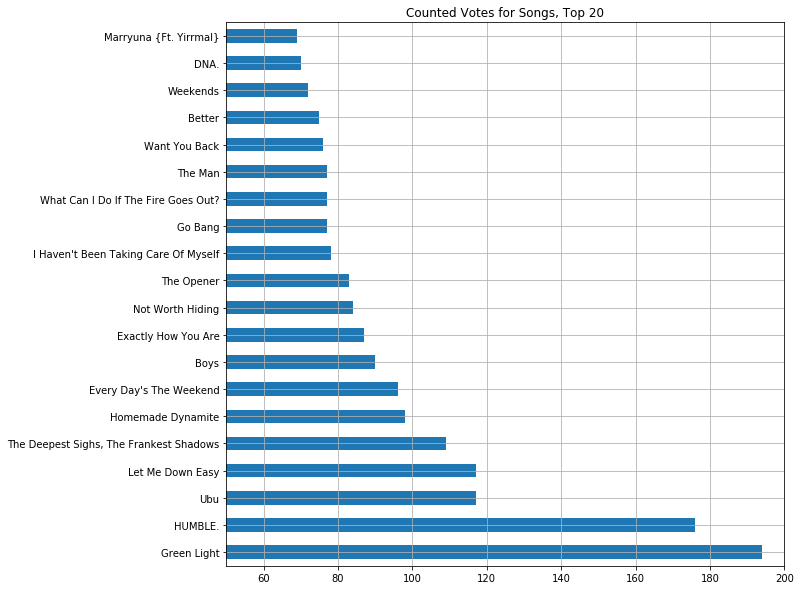

In [158]:
%matplotlib inline
top_20 = results_2018.items()[:20]
import pandas as pd

songs = [entry.split(' - ')[1] for entry in list(zip(*top_20)[0])]
bar_votes = [entry for entry in list(zip(*top_20)[1])]
song_votes = pd.DataFrame({'songs':songs,'votes':bar_votes},index=songs)
ax = song_votes.votes.plot(kind='barh',figsize=(10,10),title= "Counted Votes for Songs, Top 20",grid = True,xlim=(50,200))

